# Data Edge Academy (Onoja Anthony, Ph.D., Email: donmaston09@gmail.com)

## Introduction

The dataset used for this project is available from Kaggle and it consists of 25,000 images belonging to three categories of lung conditions:

- Normal Class
- Lung Adenocarcinomas
- Lung Squamous Cell Carcinomas

Dataset link: https://www.kaggle.com/datasets/andrewmvd/lung-and-colon-cancer-histopathological-images

Further Reading Materials
- https://www.geeksforgeeks.org/deep-learning/lung-cancer-detection-using-convolutional-neural-network-cnn/

- https://github.com/hallowshaw/Lung-Cancer-Prediction-using-CNN-and-Transfer-Learning

- https://www.nature.com/articles/s41598-025-97645-5

Follow us:
- Facebook: DataEdge Academy
- YouTube: @tonyonoja7880

Please remember to upload and run this script via Google colab

In [ ]:
# Import necessary libraries
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, Callback
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Data Extraction Phase
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')
print("Google Drive mounted successfully!")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive mounted successfully!


In [ ]:
# Parameters
IMG_SIZE = 128  # Reduced from 128 to save memory
BATCH_SIZE = 8  # Reduced from 16 to lower GPU memory usage
EPOCHS = 10
SPLIT = 0.2


In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("andrewmvd/lung-and-colon-cancer-histopathological-images")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/lung-and-colon-cancer-histopathological-images


In [ ]:
from PIL import Image

img_path = '/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/lung_image_sets/lung_aca/lungaca2056.jpeg'

img = Image.open(img_path)
img.show()


Classes found: ['lung_aca', 'lung_scc', 'lung_n']


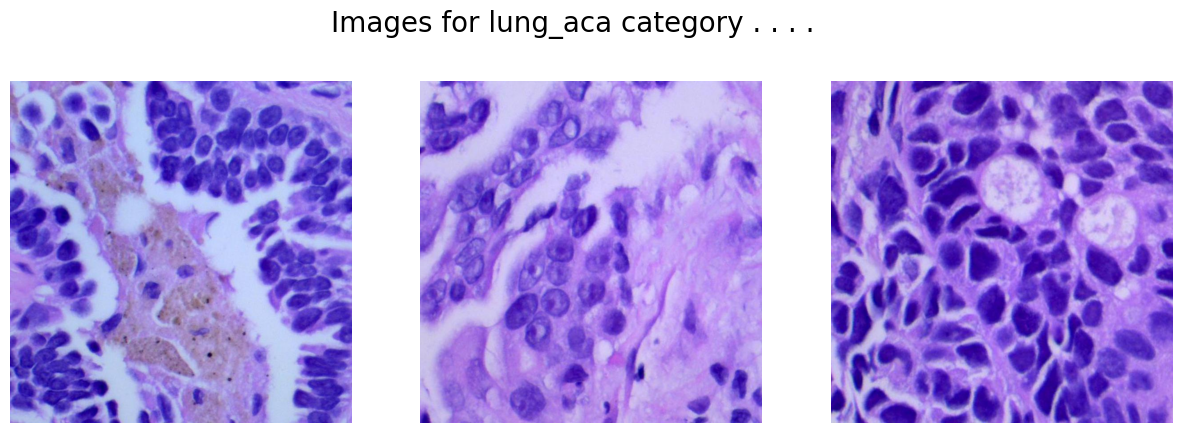

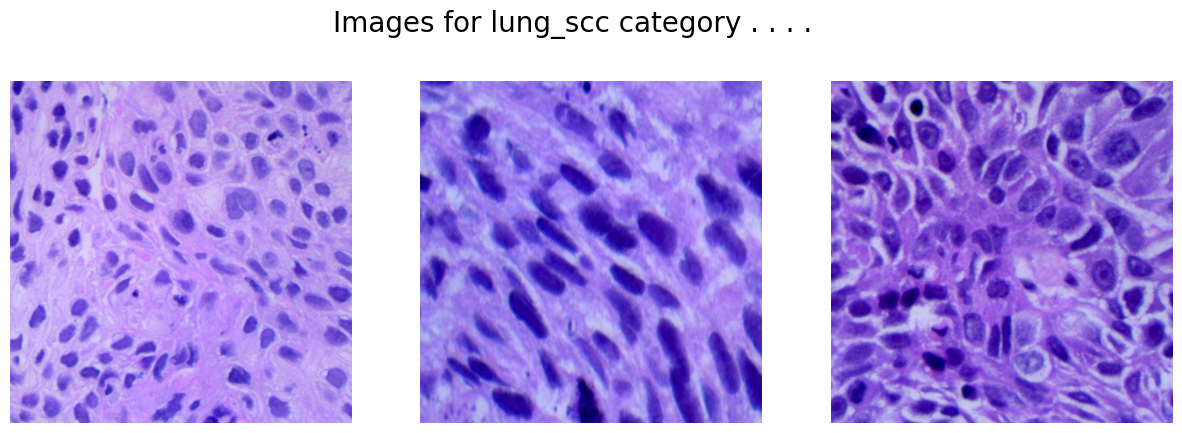

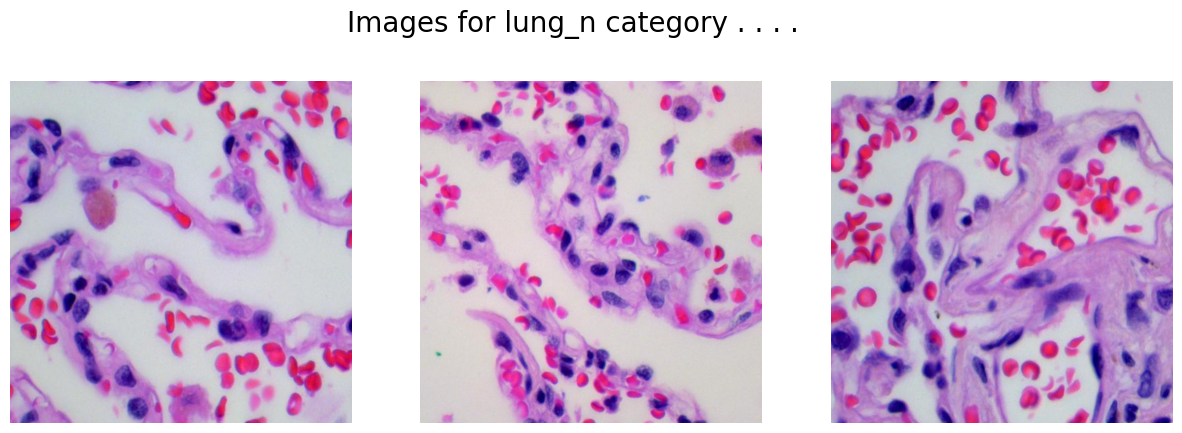

In [ ]:
import os

path = '/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/lung_image_sets'

# List all directories (categories) inside the path
classes = [folder for folder in os.listdir(path) if os.path.isdir(os.path.join(path, folder))]

print("Classes found:", classes)

for cat in classes:
    image_dir = os.path.join(path, cat)
    images = os.listdir(image_dir)

    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle(f'Images for {cat} category . . . .', fontsize=20)

    for i in range(3):
        k = np.random.randint(0, len(images))
        img = np.array(Image.open(os.path.join(image_dir, images[k])))
        ax[i].imshow(img)
        ax[i].axis('off')
    plt.show()


In [ ]:
# ImageDataGenerator for data loading and augmentation
datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values
    validation_split=SPLIT,
    rotation_range=20,  # Add light augmentation to improve generalization
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

In [ ]:
# Training data generator
train_generator = datagen.flow_from_directory(
    directory=path,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=42
)

Found 12000 images belonging to 3 classes.


In [ ]:
# Validation data generator
val_generator = datagen.flow_from_directory(
    directory=path,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False,
    seed=42
)

Found 3000 images belonging to 3 classes.


## Model Development
Let's build our CNN using TensorFlow and Keras. We'll define the architecture step-by-step:

- Sequential(): Creates a linear stack of layers for our model.

- Conv2D(): Applies convolutional filters with specified kernel size, ReLU activation, and padding to extract features.

- MaxPooling2D(): Reduces the spatial dimensions of feature maps by taking the maximum value within a pooling window.

- Flatten(): Converts the 2D feature maps into a 1D vector to feed into dense layers.

- Dense(): Fully connected layer that learns patterns with specified number of units and activation function.

- BatchNormalization(): Normalizes layer outputs to improve training speed and stability.

- Dropout(): Randomly deactivates neurons during training to prevent overfitting.

- model.summary(): Prints a detailed summary of the model’s layers, output shapes, and parameter counts.

In [ ]:
# Define the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    MaxPooling2D((2, 2)),
    BatchNormalization(),  # Moved BatchNorm earlier for stability

    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    BatchNormalization(),

    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    BatchNormalization(),

    Flatten(),
    Dense(128, activation='relu'),  # Reduced dense layer size
    BatchNormalization(),
    Dropout(0.4),  # Increased dropout to reduce overfitting
    Dense(3, activation='softmax')  # 3 classes
])

In [ ]:
# Model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,194,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,289,475 (16.36 MB)

 Trainable params: 4,288,771 (16.36 MB)

 Non-trainable params: 704 (2.75 KB)

In [ ]:
# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
# Custom callback to stop training at 90% validation accuracy
class myCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs.get('val_accuracy') is not None and logs.get('val_accuracy') > 0.90:
            print("\nValidation accuracy reached 90%, stopping training!")
            self.model.stop_training = True

# Callbacks
early_stop = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)
custom_callback = myCallback()

In [ ]:
# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=[early_stop, reduce_lr, custom_callback]
)

Epoch 1/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step - accuracy: 0.8023 - loss: 0.5360
Validation accuracy reached 90%, stopping training!
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 663s 439ms/step - accuracy: 0.8023 - loss: 0.5359 - val_accuracy: 0.9053 - val_loss: 0.4167 - learning_rate: 0.0010


In [ ]:
# Evaluate the model
val_steps = val_generator.samples // BATCH_SIZE
val_generator.reset()  # Reset generator to avoid shuffling issues
Y_pred = model.predict(val_generator, steps=val_steps)
Y_pred_classes = np.argmax(Y_pred, axis=1)
Y_true = val_generator.classes[:len(Y_pred_classes)]

375/375 ━━━━━━━━━━━━━━━━━━━━ 55s 146ms/step


In [ ]:
# Print classification report
print("\nClassification Report:")
print(classification_report(Y_true, Y_pred_classes, target_names=train_generator.class_indices.keys()))


Classification Report:
              precision    recall  f1-score   support

    lung_aca       0.86      0.85      0.86      1000
      lung_n       0.94      0.99      0.97      1000
    lung_scc       0.91      0.87      0.89      1000

    accuracy                           0.91      3000
   macro avg       0.91      0.91      0.91      3000
weighted avg       0.91      0.91      0.91      3000



375/375 ━━━━━━━━━━━━━━━━━━━━ 61s 162ms/step


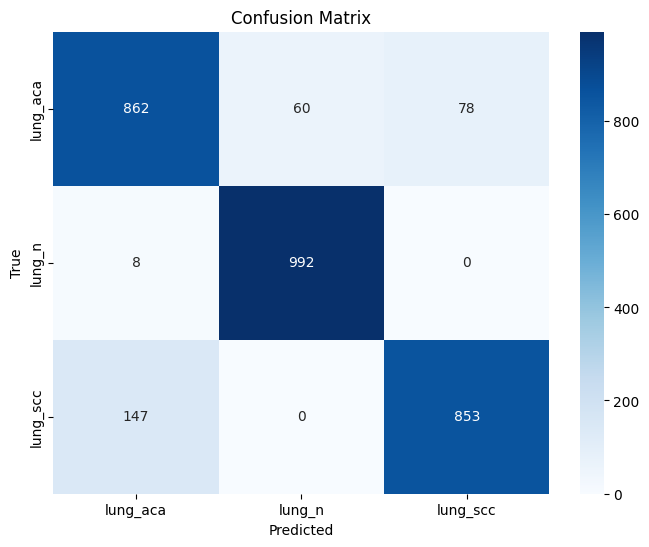

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# Predict classes
Y_pred = model.predict(val_generator)
Y_pred_classes = np.argmax(Y_pred, axis=1)
Y_true = val_generator.classes

# Class names from the generator
class_names = list(train_generator.class_indices.keys())

# Compute and plot confusion matrix
cm = confusion_matrix(Y_true, Y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
